<a href="https://colab.research.google.com/github/oleges1/PML/blob/master/lab8_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Activation, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf

## Our enviroment and some constants

In [0]:
env = gym.make('Skiing-v0')
state_size = (1, 125, 80, 3)
action_size = env.action_space.n
input_shape = (125, 80, 3)

## Convolutional network for DQN

In [3]:
import keras
import keras.backend as K
from keras.utils import conv_utils
from keras.engine import InputSpec
from keras.engine import Layer
from tensorflow import image as tfi

class ResizeImages(Layer):
    """Resize Images to a specified size

    # Arguments
        output_size: Size of output layer width and height
        data_format: A string,
            one of `channels_last` (default) or `channels_first`.
            The ordering of the dimensions in the inputs.
            `channels_last` corresponds to inputs with shape
            `(batch, height, width, channels)` while `channels_first`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".

    # Input shape
        - If `data_format='channels_last'`:
            4D tensor with shape:
            `(batch_size, rows, cols, channels)`
        - If `data_format='channels_first'`:
            4D tensor with shape:
            `(batch_size, channels, rows, cols)`

    # Output shape
        - If `data_format='channels_last'`:
            4D tensor with shape:
            `(batch_size, pooled_rows, pooled_cols, channels)`
        - If `data_format='channels_first'`:
            4D tensor with shape:
            `(batch_size, channels, pooled_rows, pooled_cols)`
    """
    def __init__(self, output_dim=(1, 1), data_format=None, **kwargs):
        super(ResizeImages, self).__init__(**kwargs)
        data_format = conv_utils.normalize_data_format(data_format)
        self.output_dim = conv_utils.normalize_tuple(output_dim, 2, 'output_dim')
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.input_spec = InputSpec(ndim=4)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            return (input_shape[0], input_shape[1], self.output_dim[0], self.output_dim[1])
        elif self.data_format == 'channels_last':
            return (input_shape[0], self.output_dim[0], self.output_dim[1], input_shape[3])

    def _resize_fun(self, inputs, data_format):
        try:
            assert keras.backend.backend() == 'tensorflow'
            assert self.data_format == 'channels_last'
        except AssertionError:
            print ("Only tensorflow backend is supported for the resize layer and accordingly 'channels_last' ordering")
        output = tfi.resize_images(inputs, self.output_dim)
        return output

    def call(self, inputs):
        output = self._resize_fun(inputs=inputs, data_format=self.data_format)
        return output

    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'padding': self.padding,
                  'data_format': self.data_format}
        base_config = super(ResizeImages, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



model = Sequential()
#model.add(ResizeImages((64, 42), input_shape=input_shape))
model.add(Conv2D(16, (10, 10), padding='valid', input_shape=input_shape))
model.add(LeakyReLU())
model.add(Conv2D(16, (5, 5), padding='same'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size = (4, 4), padding = 'same'))
model.add(LeakyReLU())
model.add(BatchNormalization(axis = -1))

model.add(Conv2D(32, (6, 6), padding='valid'))
model.add(LeakyReLU())
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size = (3, 3), padding = 'same'))
model.add(LeakyReLU())
model.add(BatchNormalization(axis = -1))
    
model.add(Conv2D(64, (4, 4), padding='same'))
model.add(LeakyReLU())
model.add(Conv2D(64, (2, 2), padding='valid'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(LeakyReLU())
model.add(BatchNormalization(axis = -1))

#model.add(Conv2D(256, (3, 3), padding='same'))
#model.add(LeakyReLU())
#model.add(Conv2D(256, (2, 2), padding='valid'))
#model.add(LeakyReLU())
#model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
#model.add(LeakyReLU())
#model.add(BatchNormalization(axis = 3))

    
#model.add(Conv2D(1, (1, 1), padding='same'))
#model.add(LeakyReLU())
#model.add(Flatten())

model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(Dense(action_size))
    
model.add(Activation('linear'))

# initiate RMSprop optimizer
model.compile(loss='mse', optimizer = 'adam', metrics = ['accuracy'])
model.summary()
graph = tf.get_default_graph()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 116, 71, 16)       4816      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 116, 71, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 116, 71, 16)       6416      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 116, 71, 16)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 18, 16)        0         
_________________________________________________________________
leaky_re_lu_3 (LeakyR

## Agent class

Prepare a special class for deep Q-learning
It has a state storage for 10000 states, network and some special functions for remembering states and updating network.

In [0]:
class DQNAgent:
    def __init__(self, state_size, action_size, model, graph, epsilon_decay = 0.999):
        self.state_size = state_size
        self.action_size = action_size
        #self.memory = deque(maxlen=2000)
        self.iters = 0
        self.memory_size = 10000
        self.memory_state = np.zeros((self.memory_size, state_size[0], state_size[1], state_size[2], state_size[3]))
        self.memory_action = np.zeros((self.memory_size))
        self.memory_reward = np.zeros((self.memory_size))
        self.memory_next_state = np.zeros((self.memory_size, state_size[0], state_size[1], state_size[2], state_size[3]))
        self.memory_done = np.zeros((self.memory_size))
        self.size = 0
        
        self.fill = 0
        
        self.alpha = 0.1     # q-learning 
        self.gamma = 0.97    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.learning_rate = 0.001
        self.model = model
        self.graph = graph
    
    def last_state_remem(self, reward, lens):
        temp_iter = self.iters
        end_iter = (self.iters - lens + self.memory_size) % self.memory_size
        while (temp_iter != end_iter):
          self.memory_reward[temp_iter] += reward
          reward *= 0.99
          self.memory_done[temp_iter] = 1
          temp_iter -= 1
          if (temp_iter < 0):
            temp_iter = self.memory_size - 9

    def remember(self, state, action, reward, next_state, done):
        #print(self.memory_state.shape, state.shape)
        self.memory_state[self.iters] = state
        self.memory_action[self.iters] = action
        self.memory_reward[self.iters] = reward
        self.memory_next_state[self.iters] = next_state
        self.memory_done[self.iters] = 0
        self.iters += 1
        self.size += 1
        if (self.iters + 10 >= self.memory_size):
          self.iters = 0
          self.fill = 1

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with self.graph.as_default():
          act_values = self.model.predict(state)
        return np.argmax(act_values)  # returns action

    def replay(self, batch_size, indx = None):
      with self.graph.as_default():
        if type(indx) == None:
          indx = self.memory_done.nonzero()[0]
        if (self.fill):
          filteration = np.random.choice(indx, batch_size)
        else:
          filteration = np.random.choice(self.iters, batch_size)
        for i in np.sort(filteration)[::-1]:
        # for state, action, reward, next_state, done in self.memory:
            #print(state.shape, action, reward, next_state.shape, done, state_size)
     
            #print(np.amax(self.model.predict(next_state.reshape(state_size))))
            
            state = self.memory_state[i]
            action = self.memory_action[i]
            reward = self.memory_reward[i]
            next_state = self.memory_next_state[i]
            
            target = reward + self.gamma * np.amax(self.model.predict(state))
            
            target_f = self.model.predict(state)
            target_f[0][int(action)] = self.alpha * target + (1 - self.alpha) * target_f[0][int(action)]
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        #if (len(self.memory) > 2000):
        #  self.memory = self.memory[batch_size:]
        #self.memory = []
        self.size = 0

    def load(self, name):
      with self.graph.as_default():
        self.model.load_weights(name)

    def save(self, name):
      with self.graph.as_default():
        self.model.save_weights(name)

We need too resize input image, so let's use:

In [0]:
from skimage.transform import resize
def prepare_state(img):
  return resize(img, (125, 80), mode = 'reflect')

Usage of this class

In [0]:
from time import time
from tqdm import tqdm
agent = DQNAgent(state_size, action_size, model, graph, epsilon_decay = 0.77)

## Learning part

Scheme of learning.
* Store some initial parties and fill a half of our state storage.
* After each game update network on 1300 states randomly sampled from storage.

In [0]:
def learning(agent, batch_size = 4096, episodes = 15, verbose = 0):
  done = False
  for e in range(episodes):
      state = env.reset()
      state = np.reshape(prepare_state(state), state_size)
      done = 0
      start = time()
      score = 0.0
      for times in range(2500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else 8000
        score += reward
        next_state = np.reshape(prepare_state(next_state), state_size)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
          print("done: {}, episode: {}/{}, score: {}, e: {:.2}, time:{} "
                      .format(done, e, episodes, score, agent.epsilon, time() - start))
          break
        if (verbose and times % 100 == 0):
          print("done: {}, episode: {}/{}, score: {}, e: {:.2}, time:{} "
                      .format(done, e, episodes, score, agent.epsilon, time() - start))
      agent.last_state_remem(reward, times)
      if (agent.iters > batch_size or agent.fill):
          indx = agent.memory_done.nonzero()[0]
          agent.replay(batch_size, indx = indx)

In [8]:
agent.epsilon = 0.9
agent.epsilon_decay = 0.77
learning(agent, verbose = 1, episodes = 15, batch_size=4096)
print(agent.epsilon)

done: False, episode: 0/15, score: -7.0, e: 0.9, time:0.005235910415649414 
done: False, episode: 0/15, score: -523.0, e: 0.9, time:1.6619155406951904 
done: False, episode: 0/15, score: -1023.0, e: 0.9, time:2.229205846786499 
done: False, episode: 0/15, score: -1534.0, e: 0.9, time:2.793581962585449 
done: False, episode: 0/15, score: -2022.0, e: 0.9, time:3.365571975708008 
done: False, episode: 0/15, score: -2553.0, e: 0.9, time:3.8887765407562256 
done: False, episode: 0/15, score: -3047.0, e: 0.9, time:4.4655797481536865 
done: False, episode: 0/15, score: -3534.0, e: 0.9, time:5.007403373718262 
done: False, episode: 0/15, score: -4044.0, e: 0.9, time:5.587691783905029 
done: False, episode: 0/15, score: -4523.0, e: 0.9, time:6.182501316070557 
done: False, episode: 0/15, score: -5021.0, e: 0.9, time:6.740368843078613 
done: False, episode: 0/15, score: -5518.0, e: 0.9, time:7.30739688873291 
done: False, episode: 0/15, score: -6011.0, e: 0.9, time:7.87568473815918 
done: False,

## Save result

In [0]:
agent.save('best.h5')

## Play in jupyter notebook

In [0]:
def show_agent_play(env, agent):
    state = env.reset()
    state = np.reshape(prepare_state(state), state_size)
    env.render(mode='rgb_array')
    done = False
    episode_reward = 0
    while done != True:
        a = agent.act(state)
        state2, reward, done, info = env.step(a)
        episode_reward += reward
        env.render()
        state = np.reshape(prepare_state(state2), state_size)
    env.close()
    return episode_reward

In [0]:
agent.load('best.h5')
agent.epsilon = 0.0

In [0]:
show_agent_play(env, agent)

NoSuchDisplayException: ignored

### About agent playing

If `epsilon = 0.0`, agent sky down the slope, ignoring flags.
If epsilon is bigger you may notice some random actions.

## Playing in colab:

In [0]:
agent.epsilon = 0.0

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [0]:
from time import sleep
def show_agent_play(env, agent):
    state = env.reset()
    state = np.reshape(prepare_state(state), state_size)
    plt.imshow(env.render(mode='rgb_array'))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    done = False
    episode_reward = 0
    while done != True:
        a = agent.act(state)
        state2, reward, done, info = env.step(a)
        episode_reward += reward
        plt.imshow(env.render(mode='rgb_array'))
        #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        state = np.reshape(prepare_state(state2), state_size)
    env.close()
    return episode_reward

KeyboardInterrupt: ignored

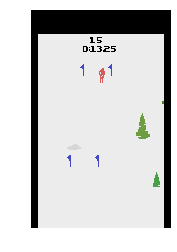

In [13]:
show_agent_play(env, agent)

## Save data

In [14]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

def saver(name):
  file_metadata = {
    'name': name + '.h5',
    'mimeType': 'application/octet-stream'
  }
  media = MediaFileUpload(name + '.h5', 
                          mimetype='application/octet-stream',
                          resumable=True)
  created = drive_service.files().create(body=file_metadata,
                                         media_body=media).execute()
  print('File ID: {}'.format(created.get('id')))

    100% |████████████████████████████████| 993kB 16.1MB/s 


In [15]:
! ls -a

.  ..  adc.json  best.h5  .config  sample_data


In [16]:
saver('best')

File ID: 1lp9toQ0M_g1rsW_91qpogZ258FZ76xDX
